In [1]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.lines import Line2D


#from netwulf import visualize
#import netwulf as nw
#from numba import jit

#import pydot
from graph_rune import create_bipartite_graph, set_politician_attributes, create_color_map
import networkx as nx
#import community for community detection
import community as community_louvain

import datetime

ModuleNotFoundError: No module named 'fa2'

### Goal: investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

In [29]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)


### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

After having check a few periods, it seems to make sense to make a threshold at 90% of max votes

In [30]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [31]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [32]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [33]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)


In [34]:
df['votes_adjusted'].isna().sum()

0

In [35]:
#We make a new pandas dataframe, where we go through votes_adjusted and only keep the votes from active politicians
df_active = pd.DataFrame(columns=['periode_id', 'votes_adjusted'])
for index, row in df.iterrows():
    votes_adjusted = row['votes_adjusted']
    votes_adjusted = [vote for vote in votes_adjusted if vote['aktørid'] in dict_active_politicians[row['periode_id']]]
    df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)


C:\Users\rune7\AppData\Local\Temp\ipykernel_16424\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_16424\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_16424\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel

In [36]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


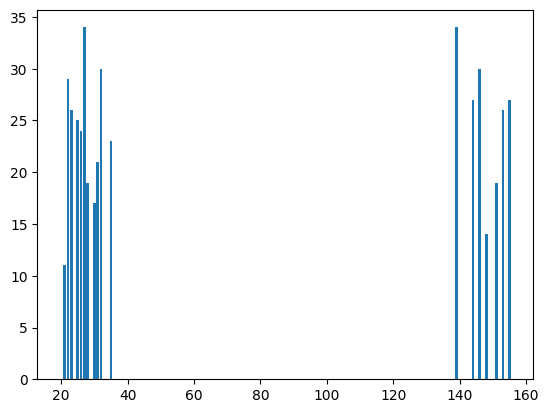

The average number of politicians dropped per period is 19.818181818181817


In [37]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

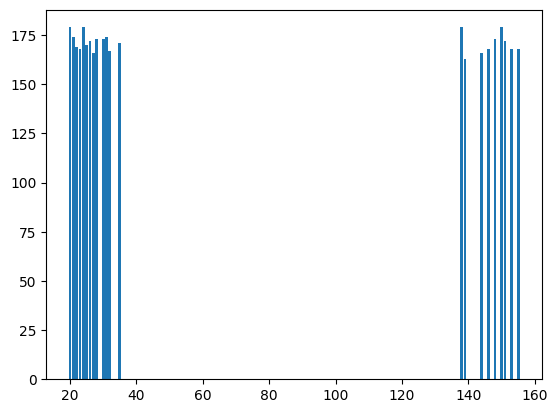

The average number of politicians that we consider per period is 171.4090909090909


In [38]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [39]:
df_active['votes_adjusted'].isna().sum()

0

In [40]:
df_active.head()

,periode_id,votes_adjusted
0,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,31,"[{'id': 850408, 'typeid': 1, 'afstemningid': 4..."
2,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [41]:
#add the df_active to the df
df['votes_adjusted_active'] = df_active['votes_adjusted']

In [42]:
#pickle the new dataframe
#with open('df_law_active.pickle', 'wb') as f:
#   pickle.dump(df, f)

#load data from df_law_active.pickle
with open('df_law_active_rune.pickle', 'rb') as f:
    df = pickle.load(f)

In [43]:
#remove nan
df = df[df['votes_adjusted_active'].notna()]

#count nan
df['votes_adjusted_active'].isna().sum()

0

In [44]:
#create a networkx graph for period 32
df32 = df[df['periode_id'] == 148]

G = create_bipartite_graph(df32)

#set attributes for politicians
G = set_politician_attributes(G)

In [45]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [46]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)

color_map = create_color_map() #defined in graph_functions.py

No isolate nodes


In [47]:

G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

pos = nx.kamada_kawai_layout(G_uni)
#pos = nx.fruchterman_reingold_layout(G_uni, k=0.5, iterations=50)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])



TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [413]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))


3


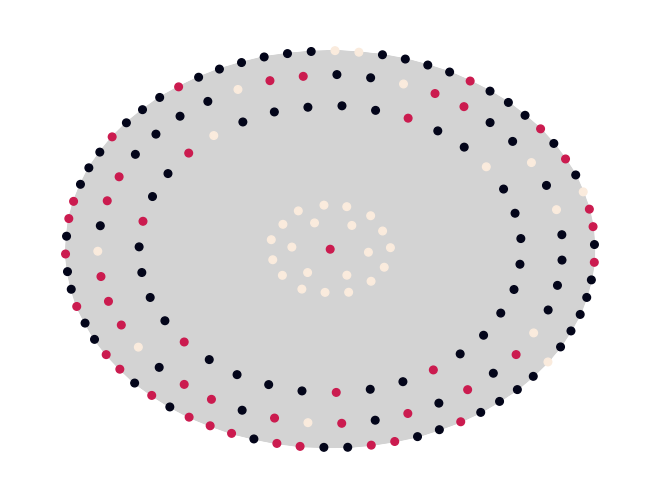

In [414]:
#plot the graph with the clusters
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()])
plt.show()

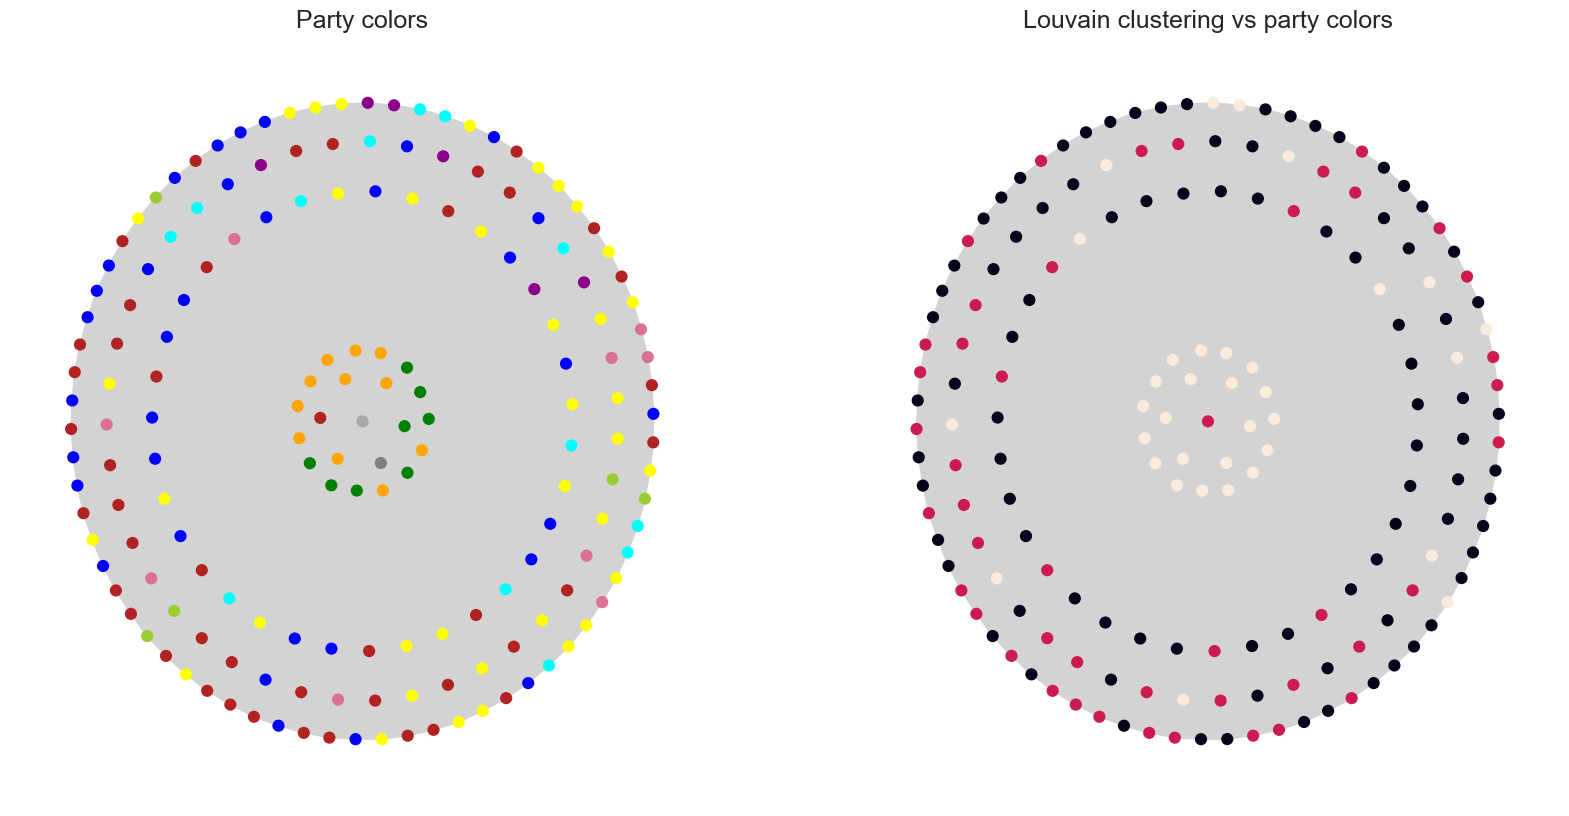

In [415]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#create random colors for the clusters
colors = [np.random.rand(3,) for i in range(len(set(partition.values())))]

#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()], ax=ax2)
#plot it with party colors
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax1)

ax2.set_title('Louvain clustering')
ax1.set_title('Party colors')
plt.title('Louvain clustering vs party colors')
plt.show()

In [272]:
#Who is the grey (out of folketingsgruppe) politician?
for node in G_uni.nodes():
    if G_uni.nodes[node]['color'] == 'grey':
        #print name attribute of the node
        print(G_uni.nodes[node]['name'])

Uffe Elbæk


In [273]:
#Uffe Elbæk left radikale venstre in 2013, and this period covers 2014-2015 - makes sense.

In [274]:
#import backbone
import backbone_network as bb

#make a backbone network
G_backbone = bb.get_graph_backbone(G_uni, 0.5)


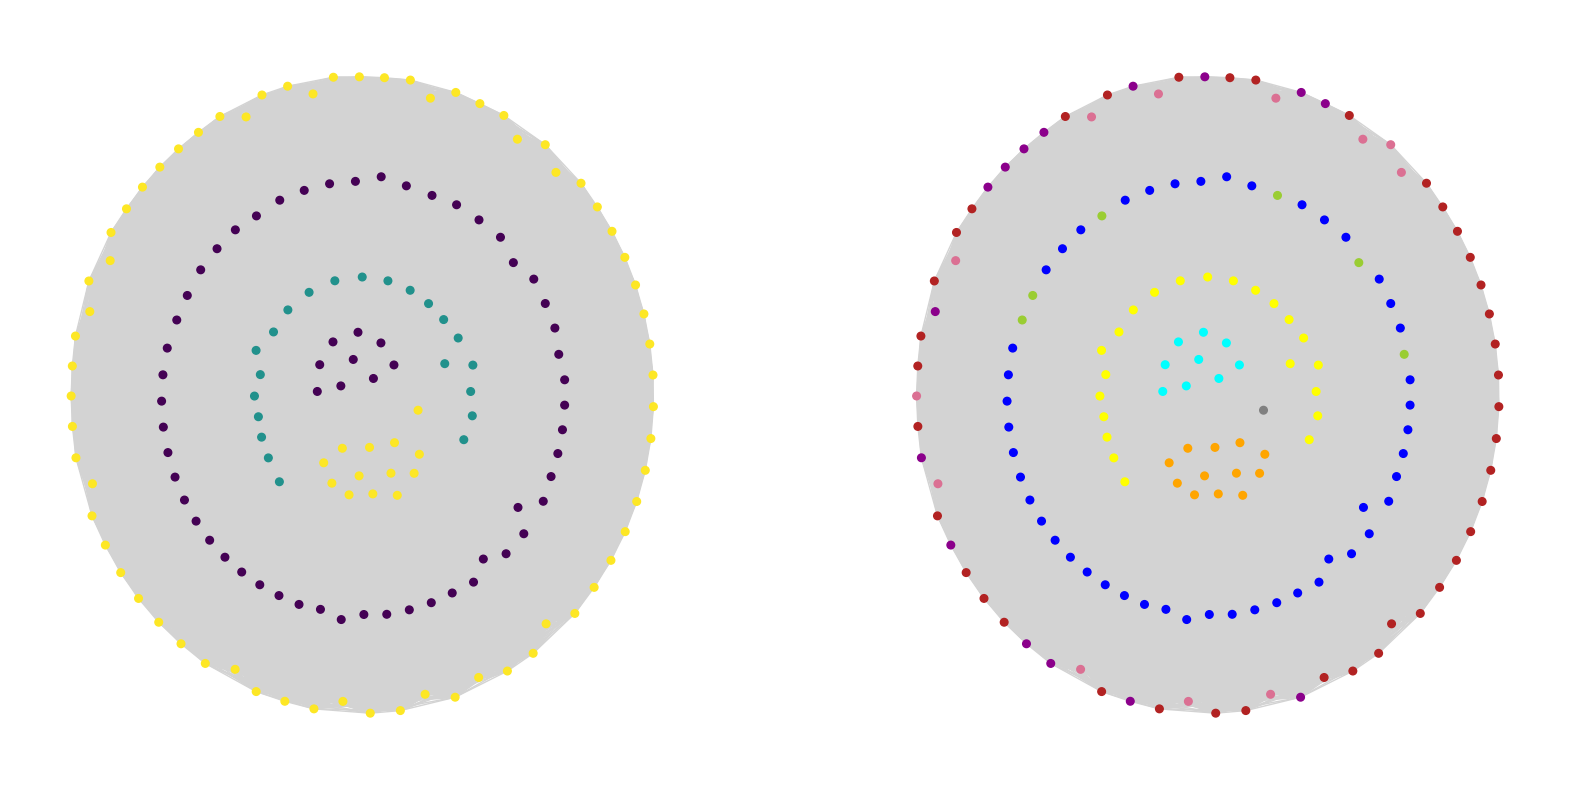

In [275]:
#plot the backbone network
pos = nx.kamada_kawai_layout(G_backbone, weight='weight', scale=100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_backbone.nodes()], ax=ax1)
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_backbone.nodes[node]['color'] for node in G_backbone.nodes()], ax=ax2)


### We first plot the clustering over time for each period and check if the same parties are in the same clusters and if certain individuals are not in the same cluster as their party

In [276]:
#loading politician info from pickle politician_df_clean.pkl
with open('politician_df_clean.pkl', 'rb') as f:
    politician_df = pickle.load(f)

politician_df.head()

#set the index to politician_id
politician_df = politician_df.set_index('politician_id')

c:\Users\rune7\anaconda3\envs\css\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [277]:
#We make a dict where we have the periode_id as key and the aktør_id with their party and partition as value
partition_all_periods = pd.DataFrame()

#unique periods
periods = df['periode_id'].unique()

trouble_ids = []

for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)
    
    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #Do clustering on the graph using the Louvain algorithm
    partition = community_louvain.best_partition(G_uni)

    
    period_dict = defaultdict()
    for id in partition.keys():
        try:
            #get party of id
            party = politician_df.loc[id]['party'][periode_id]
            period_dict[id] = [party, partition[id],periode_id]
            period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
        except KeyError:
            trouble_ids.append({'id':id, 'periode_id':periode_id})
            print(f'KeyError for id {id} and periode_id {periode_id}')
            pass

    
    partition_all_periods = partition_all_periods.append(period_df)



Working on periode_id 32
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 31
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 30
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 28
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 35
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 27
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 138
No isolate nodes
Working on periode_id 139
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 144
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 146
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 26
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 24
No isolate nodes
Working on periode_id 25
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 23
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 22
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 21
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 20
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 148
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 150
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 151
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 153
No isolate nodes
KeyError for id 19809 and periode_id 153
Working on periode_id 155


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


In [279]:
#This function finds non-conformers for all parties for all periods
def find_non_conformers(partition_all_periods):
    non_conformers = pd.DataFrame()
    parties = partition_all_periods['party'].unique()
    for party in parties:
        #get subset of partition_all_periods for the party
        df_party = partition_all_periods[partition_all_periods['party'] == party]
        #get the partition number for the party for each period
        periods = df_party['periode_id'].unique()
        for period in periods:
            #get subset of partition_all_periods for the party and period
            df_period = df_party[df_party['periode_id'] == period]
            #get the partition number for the party
            party_partition_number = df_period['partition'].unique()[0]
            #get the subset of partition_all_periods for the party and period where the partition number is not the same as the party
            non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
    return non_conformers

non_conformers = find_non_conformers(partition_all_periods)

#We add the politician name to the non_conformers
for id in non_conformers.index:
    non_conformers.loc[id, 'politician_name'] = politician_df.loc[id]['politician_name']
non_conformers

C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The fram

,party,partition,periode_id,politician_name
44,Enhedslisten,1,153,Henning Hyllested
16503,Socialdemokratiet,1,153,Anne Paulin
152,Socialdemokratiet,1,153,Ida Auken
19637,"Venstre, Danmarks Liberale Parti",1,153,Kenneth Mikkelsen
19807,"Venstre, Danmarks Liberale Parti",1,153,Anne Rasmussen
18701,"Venstre, Danmarks Liberale Parti",1,153,Marie Bjerre
219,Socialistisk Folkeparti,1,153,Lisbeth Bech-Nielsen
4969,Radikale Venstre,1,25,Jørgen Poulsen
18728,Radikale Venstre,1,153,Anne Sophie Callesen
17141,Det Konservative Folkeparti,1,153,Brigitte Klintskov Jerkel


In [290]:
#We check which partition people from socialdemokratiet are in
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')


partition
1    934
2      2
dtype: int64

In [291]:

#This means we have to change it such that the partition number is consistent across periods

#First we find out which partitition number is most common for socialdemokratiet for each period
soc_partition = partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].groupby('periode_id').agg(lambda x:x.value_counts().index[0])

In [292]:
#For all periods where the partition number is not 1, we change it to 1 and we change the partition number for the other parties accordingly
for periode_id in soc_partition.index:
    #get subset of partition_all_periods for the periode_id
    df_period = partition_all_periods[partition_all_periods['periode_id'] == periode_id]
    #get the partition number for socialdemokratiet
    soc_partition_number = soc_partition.loc[periode_id]['partition']
    #if the partition number is not 1, we change it to 1
    if soc_partition_number != 1:
        #We first move all the parities with soc_partition_number to partition 10 (which is not used)
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == soc_partition_number), 'partition'] = 10
        #We then move all the parties with partition number 1 to soc_partition_number
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 1), 'partition'] = soc_partition_number
        #We then move all the parties with partition number 10 to 1
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 10), 'partition'] = 1

In [293]:
#We check that it worked
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')
#This means that two persons from Socialdemokratiet were not assigned to the same parititon as the rest of the party


partition
1    934
2      2
dtype: int64

In [294]:
#In general there are quite few non-conformers. So when plotting the graph, we will simply plot each party as a group

#We save the partition_all_periods as a pickle
partition_all_periods.to_pickle('partition_all_periods.pkl')

In [295]:
#We exctract the most common partition for all parties for all periods in partition_all_periods
party_partition = partition_all_periods.groupby(['party', 'periode_id']).agg(lambda x:x.value_counts().index[0])
party_partition['partition']

party                             periode_id
Alternativet                      138           1
                                  139           1
                                  144           0
                                  146           0
                                  148           0
                                               ..
Venstre, Danmarks Liberale Parti  148           2
                                  150           1
                                  151           0
                                  153           0
                                  155           0
Name: partition, Length: 223, dtype: int64

In [299]:
#count laws in each period
df.groupby('periode_id').count()['afstemnings_id']


periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

In [296]:
common_partition = defaultdict()
#unique parties 
parties = partition_all_periods['party'].unique()
#drop Tjóðveldisflokkurin, 'Inuit Ataqatigiit',  'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne',Fólkaflokkurin and 'Uden for folketingsgrupperne',
parties = parties[~np.isin(parties, ['Tjóðveldisflokkurin', 'Inuit Ataqatigiit', 'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne','Fólkaflokkurin',  'Uden for folketingsgrupperne'])]

In [304]:
party_period = defaultdict()
periods = partition_all_periods['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 7, 150])]
for party in parties:
    #get a subset of party_partition for the party
    df_party = party_partition.loc[party]
    for period in periods:
        #Check that df_party has the period
        if period in df_party.index:
            #get the partition number for the party and period
            party_period[(party, period)] = df_party.loc[period]['partition']
        else:
            #if the party did not exist in the period, we set the partition number to 0
            party_period[(party, period)] = None

In [305]:
party_period

defaultdict(None,
            {('Enhedslisten', 32): 1,
             ('Enhedslisten', 31): 1,
             ('Enhedslisten', 30): 1,
             ('Enhedslisten', 28): 1,
             ('Enhedslisten', 35): 1,
             ('Enhedslisten', 27): 1,
             ('Enhedslisten', 138): 1,
             ('Enhedslisten', 139): 1,
             ('Enhedslisten', 144): 0,
             ('Enhedslisten', 146): 0,
             ('Enhedslisten', 26): 1,
             ('Enhedslisten', 25): 1,
             ('Enhedslisten', 23): 1,
             ('Enhedslisten', 22): 1,
             ('Enhedslisten', 21): 1,
             ('Enhedslisten', 20): 1,
             ('Enhedslisten', 148): 0,
             ('Enhedslisten', 151): 1,
             ('Enhedslisten', 153): 1,
             ('Enhedslisten', 155): 1,
             ('Socialdemokratiet', 32): 1,
             ('Socialdemokratiet', 31): 1,
             ('Socialdemokratiet', 30): 1,
             ('Socialdemokratiet', 28): 1,
             ('Socialdemokratiet', 35): 1,

### We now plot the parties clustering over time
First we identify the dates corresponding to each period

In [306]:
#We look through the df dato_sagstrin that is a datetime format and we extract the min and max date for each periode_id
periods_dict = defaultdict()
for period in periods:
    #get subset of dato_sagstrin for the period
    df_period = df[df['periode_id'] == period]
    #get the min and max date
    min_date = df_period['dato_sagstrin'].min()
    #convert to datetime
    min_date = datetime.datetime.strptime(min_date[:-9], '%Y-%m-%d')
    max_date = df_period['dato_sagstrin'].max()
    #convert to datetime
    max_date = datetime.datetime.strptime(max_date[:-9], '%Y-%m-%d')
    #find the date in the middle of the period
    middle_date = min_date + (max_date - min_date)/2
    periods_dict[period] = [min_date, middle_date, max_date]
 



In [308]:
color_map = create_color_map()


In [312]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [449]:
elections = [datetime.datetime(2005, 11, 13, 0, 0),
 datetime.datetime(2007, 11, 18, 0, 0),
 datetime.datetime(2011, 11, 15, 0, 0),
 datetime.datetime(2015, 11, 21, 0, 0),
 datetime.datetime(2019, 11, 5, 0, 0),
 datetime.datetime(2022, 11, 1, 0, 0)]

In [318]:
#Make new party order from most left to most right (aproximately)
parties = ['Enhedslisten','Socialistisk Folkeparti', 'Alternativet','Radikale Venstre', 'Socialdemokratiet', 'Venstre, Danmarks Liberale Parti', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Ny Alliance', 'Liberal Alliance', 'Nye Borgerlige']

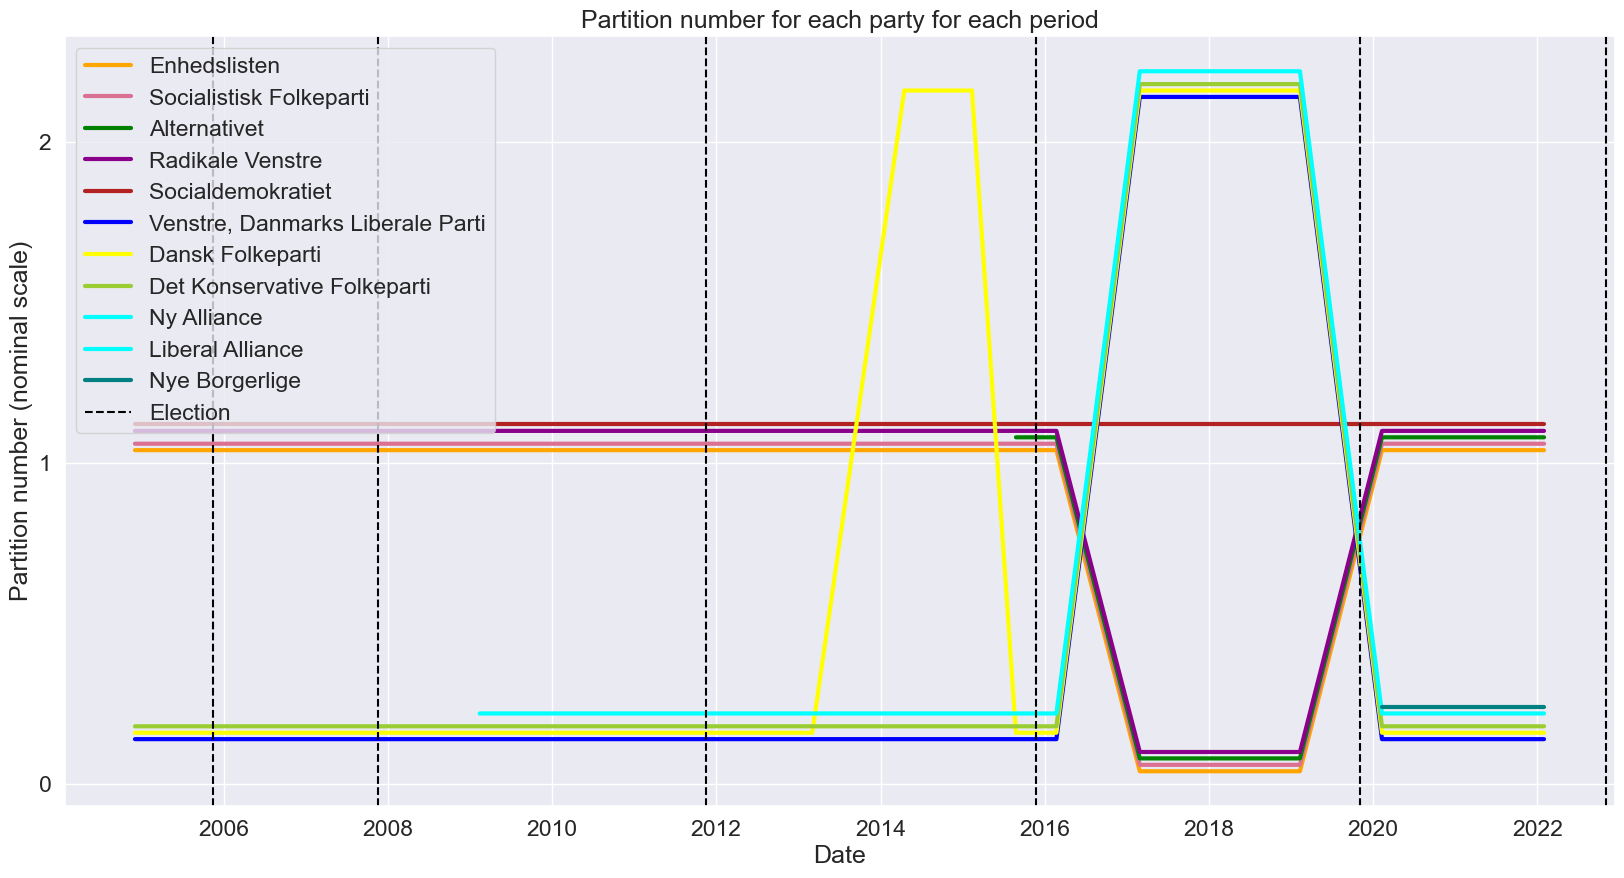

In [349]:
#We plot all the parties
import seaborn as sns

sns.set_style("darkgrid")

#set text size
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0
constant = -0.04
for party in parties:
    #We get the partition number for the party for each period
    partition_number = [party_period[(party, period)] for period in periods]
    #add offset if the entries in partition_number are not None
    partition_number = [x + offset - constant if x is not None else x for x in partition_number]
    #We plot the partition number for the party for each period
    ax.plot(middle_date, partition_number, label = party, color = color_map[party], linewidth = 3)
    offset = offset + 0.02
#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')

ax.legend()


#make y ticks only be 0, 1, 2
ax.set_yticks([0, 1, 2])
ax.set_xlabel('Date')
ax.set_ylabel('Partition number (nominal scale)')
ax.set_title('Partition number for each party for each period')
plt.show()


### We now move onto clusterting distance from Socialdemokratiet

In [439]:
#get laws per period
df.groupby('periode_id').count()['afstemnings_id']

periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

Currently removing 153 because it causes a problem (related to corona) and not sure how to fix it

In [461]:
#unique periods
periods = df['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 7, 150, 153])]


distance_all_periods = defaultdict()

right_wing_parites = ['Venstre, Danmarks Liberale Parti', 'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Ny Alliance']


for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)

    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #We take all social democrats as a grouip
    soc_politicians = [node for node in G_uni.nodes() if G_uni.nodes[node]['party'][periode_id] == 'Socialdemokratiet']

    other_parties = [party for party in parties if party != 'Socialdemokratiet']
    distances = defaultdict()
    #We calculate the average weight of the edges between the social democrats and the other parties
    for party in other_parties:
        #get the nodes for the party
        nodes_party = [node for node in G_uni.nodes if G_uni.nodes[node]['party'][periode_id] == party]
        if len(nodes_party) == 0:
            continue
        #calculate the average weight of the edges between the social democrats and the other party
        average_weight = np.mean([G_uni.edges[(soc_politician, node)]['weight'] for soc_politician in soc_politicians for node in nodes_party])
        distances[party] = average_weight

    #We normalize the distances
    max_distance = max(distances.values())
    min_distance = min(distances.values())
    distances = {party: (distance - min_distance)/(max_distance - min_distance) for party, distance in distances.items()}
    #We flip the distances
    distances = {party: 1 - distance for party, distance in distances.items()}

    #if the party is right wing we make the distance negative
    distances = {party: -distance if party in right_wing_parites else distance for party, distance in distances.items()}

    distance_all_periods[periode_id] = distances





Working on periode_id 32
No isolate nodes
Working on periode_id 31
No isolate nodes
Working on periode_id 30
No isolate nodes
Working on periode_id 28
No isolate nodes
Working on periode_id 35
No isolate nodes
Working on periode_id 27
No isolate nodes
Working on periode_id 138
No isolate nodes
Working on periode_id 139
No isolate nodes
Working on periode_id 144
No isolate nodes
Working on periode_id 146
No isolate nodes
Working on periode_id 26
No isolate nodes
Working on periode_id 25
No isolate nodes
Working on periode_id 23
No isolate nodes
Working on periode_id 22
No isolate nodes
Working on periode_id 21
No isolate nodes
Working on periode_id 20
No isolate nodes
Working on periode_id 148
No isolate nodes
Working on periode_id 151
No isolate nodes
Working on periode_id 155
No isolate nodes


In [462]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [463]:
#We go through the distance_all_periods and assign each party a None value if the party is not in the distance_all_periods
for party in parties:
    for periode_id in periods:
        if party not in distance_all_periods[periode_id]:
            distance_all_periods[periode_id][party] = None


In [464]:
distance_all_periods

defaultdict(None,
            {32: {'Enhedslisten': 0.7334879776514021,
              'Socialistisk Folkeparti': 0.0354684226279558,
              'Radikale Venstre': 0.0,
              'Venstre, Danmarks Liberale Parti': -0.5670489788380342,
              'Dansk Folkeparti': -0.8812957470545022,
              'Det Konservative Folkeparti': -0.5385613089893249,
              'Liberal Alliance': -1.0,
              'Alternativet': None,
              'Socialdemokratiet': None,
              'Ny Alliance': None,
              'Nye Borgerlige': None},
             31: {'Enhedslisten': 0.5213348314514423,
              'Socialistisk Folkeparti': 0.0,
              'Radikale Venstre': 0.000839302183705537,
              'Venstre, Danmarks Liberale Parti': -0.5705960770941986,
              'Dansk Folkeparti': -0.7300029896382241,
              'Det Konservative Folkeparti': -0.5689692358570598,
              'Liberal Alliance': -1.0,
              'Alternativet': None,
              'Social

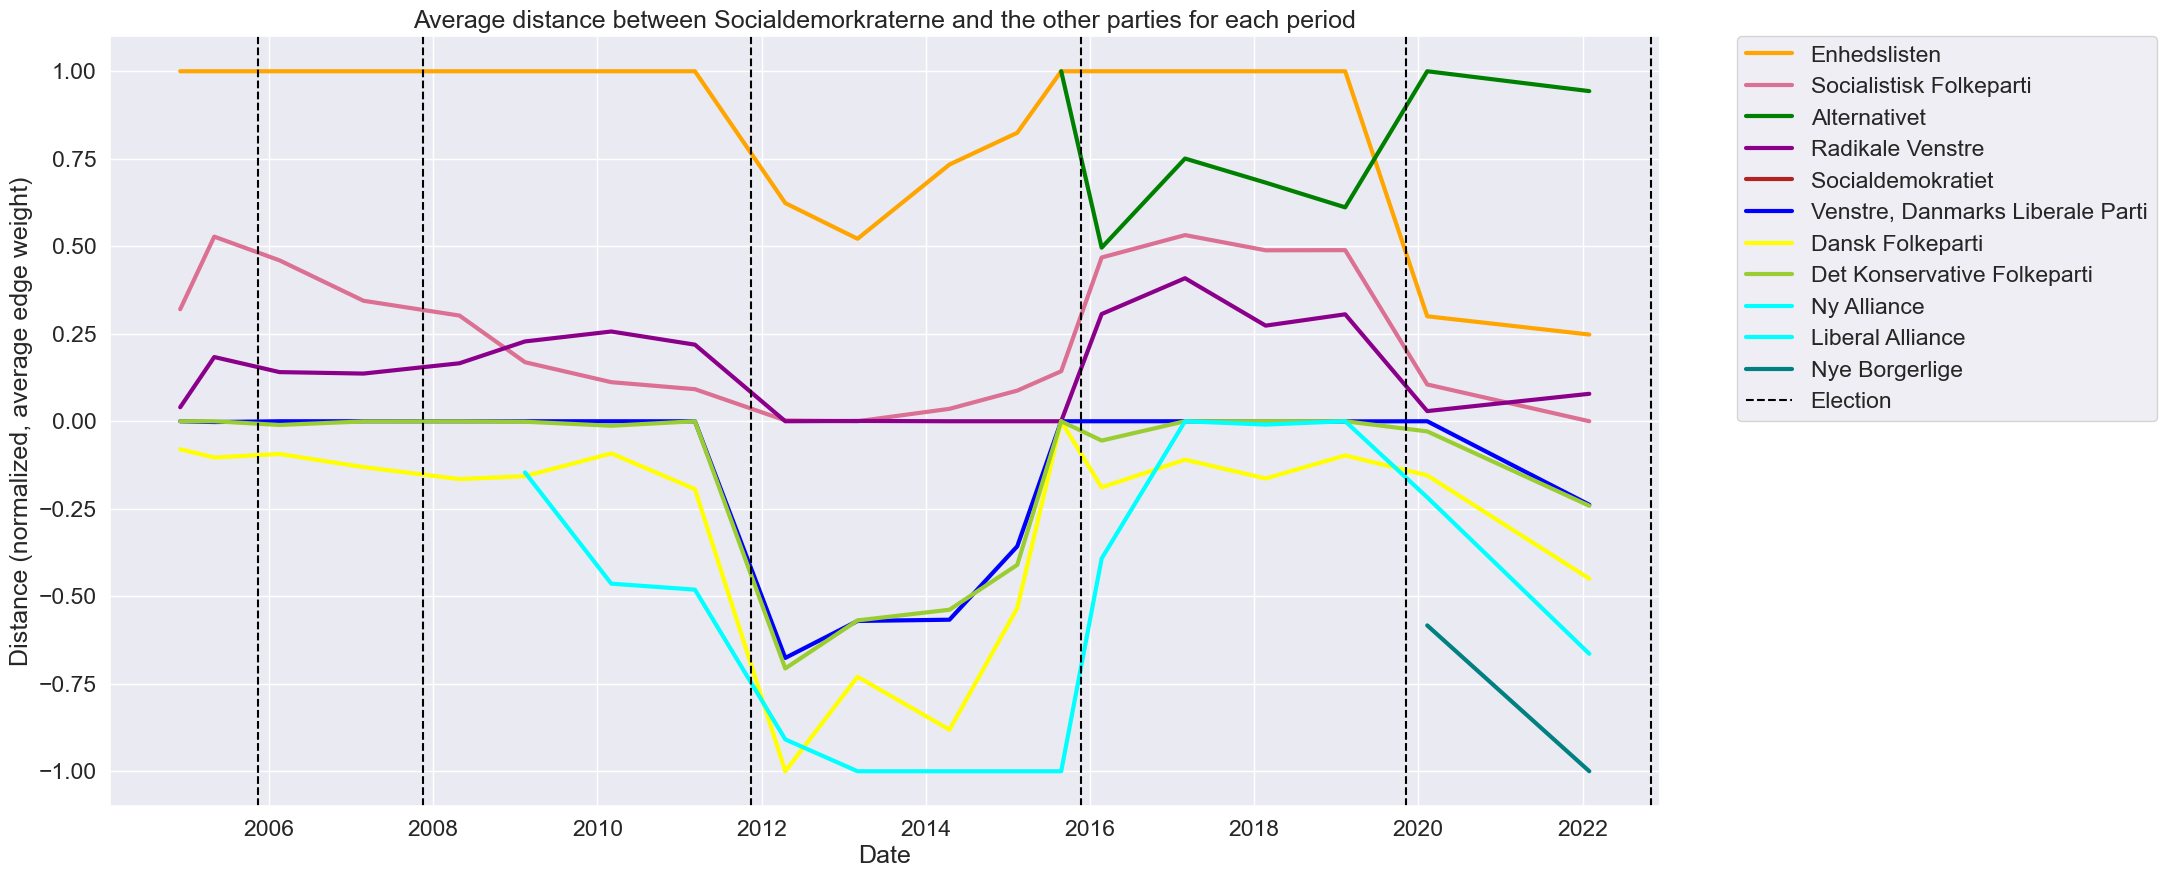

In [465]:
#We plot all the parties
import seaborn as sns

#We plot the distance between the social democrats and the other parties
sns.set_style("darkgrid")

#set text size
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0.02
for party in parties:
    #We get the partition number for the party for each period if the distance is not None
    distance = [distance_all_periods[period][party] for period in periods if distance_all_periods[period][party] is not None]
    middle_date = [periods_dict[period][1] for period in periods if distance_all_periods[period][party] is not None]
    ax.plot(middle_date, distance, label = party, color = color_map[party], linewidth = 3)
    

#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')
#ax.axvline(datetime.datetime(2008,8,28), color = 'black', linestyle = '-', label = 'Ny Alliance becomes Liberal Alliance')

#plot legend outside of plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Date')
ax.set_ylabel('Distance (normalized, average edge weight)')
ax.set_title('Average distance between Socialdemorkraterne and the other parties for each period')
plt.show()






In [460]:
#get dates for period 153
df[df['periode_id'] == 153]['dato_sagstrin']

3282    2020-10-22T00:00:00
3283    2020-11-12T00:00:00
3284    2020-11-19T00:00:00
3285    2020-11-19T00:00:00
3286    2020-11-24T00:00:00
               ...         
3595    2021-06-24T00:00:00
3596    2021-06-24T00:00:00
3597    2021-06-24T00:00:00
3598    2021-06-24T00:00:00
3599    2021-08-27T00:00:00
Name: dato_sagstrin, Length: 252, dtype: object